<a href="https://colab.research.google.com/github/codecx07/Amex-Data-Challenge-2019/blob/master/Amex_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install impyute

In [0]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from keras.utils import np_utils

from impyute.imputation.cs import fast_knn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

%matplotlib inline
warnings.filterwarnings('ignore')
sys.setrecursionlimit(100000)

In [0]:
# Link Google drive with Colab Notebook
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download files from Google Drive to Colab Notebook
id = '1Qw3RTMH0NMAOmllNjSzIy_AJS3NJ8YNy'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')

In [0]:
del[df['VAR1']]

In [0]:
df['VAR14'].replace('.', np.nan, inplace = True)
df['VAR14'] = df['VAR14'].apply(pd.to_numeric)

In [0]:
threshold = 0.7
#Dropping columns with missing value rate higher than threshold
df = df[df.columns[df.isnull().mean() < threshold]]
threshold = 0.5
#Dropping rows with missing value rate higher than threshold
df = df.loc[df.isnull().mean(axis=1) < threshold]

In [0]:
X = df.drop(["VAR21"], axis=1) # drop labels for training set
y = df["VAR21"].copy()

In [0]:
y = y.values

In [0]:
ordinal_encoder = OrdinalEncoder()
Y_encoded = ordinal_encoder.fit_transform(y.reshape(-1, 1))
Y_encoded.shape

(33844, 1)

In [0]:
features = X.columns
X_imputed = pd.DataFrame(fast_knn(X.values, k = 10), columns=features)

In [0]:
def cleaner(df):
    
    df.loc[df['VAR9'] > 100, 'VAR9'] = df['VAR9'] / 10
    df.loc[df['VAR10'] > 100, 'VAR10'] = df['VAR10'] / 10
    df.loc[df['VAR17'] > 100, 'VAR17'] = df['VAR17'] / 10
    df['Score'] = df['VAR2'] / df['VAR4']
    df['Expenses'] = df['VAR6'] - df['VAR3']
    df['Balance_to_pay'] = df['VAR8'] - df['VAR7']
    # df['VAR22'] = df['VAR8'] / df['VAR7']
    # df['Max_Credit_Line'] = df[['VAR13', 'VAR15']].max(axis = 1)
    df['Avg_Credit_Line'] = (df['VAR13'] + df['VAR15']) / 2
    df['Increase_in_Payment'] = df['VAR16'] / df['VAR7']

    log_list = ['VAR2', 'VAR3', 'VAR5', 'VAR6', 'VAR7', 'VAR9',
                'VAR10', 'VAR11', 'VAR12',
                'VAR19', 'VAR20', 'Score', 'Avg_Credit_Line', 'Increase_in_Payment']
    for i in log_list:
        df[i + '_log'] = np.log(df[i] + 1)

    df.drop(labels = log_list, axis = 1, inplace = True)
    df.drop(labels = ['VAR4', 'VAR8', 'VAR13', 'VAR14', 'VAR15', 'VAR16', 'VAR17', 'VAR18'], axis = 1, inplace = True)
    
    return df

In [0]:
X_transform = X_imputed.copy()
X_imputed_feature = cleaner(X_transform)
features = X_imputed_feature.columns

# X_imputed_feature = pd.DataFrame(imputer.transform(X), columns = X.columns)

In [0]:
X_imputed_feature.columns

Index(['Expenses', 'Balance_to_pay', 'VAR2_log', 'VAR3_log', 'VAR5_log',
       'VAR6_log', 'VAR7_log', 'VAR9_log', 'VAR10_log', 'VAR11_log',
       'VAR12_log', 'VAR19_log', 'VAR20_log', 'Score_log',
       'Avg_Credit_Line_log', 'Increase_in_Payment_log'],
      dtype='object')

In [0]:
X_imputed_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33844 entries, 0 to 33843
Data columns (total 16 columns):
Expenses                   33844 non-null float64
Balance_to_pay             33844 non-null float64
VAR2_log                   33844 non-null float64
VAR3_log                   33844 non-null float64
VAR5_log                   33844 non-null float64
VAR6_log                   33844 non-null float64
VAR7_log                   33844 non-null float64
VAR9_log                   33844 non-null float64
VAR10_log                  33844 non-null float64
VAR11_log                  33844 non-null float64
VAR12_log                  33844 non-null float64
VAR19_log                  33844 non-null float64
VAR20_log                  33844 non-null float64
Score_log                  33844 non-null float64
Avg_Credit_Line_log        33844 non-null float64
Increase_in_Payment_log    33844 non-null float64
dtypes: float64(16)
memory usage: 4.1 MB


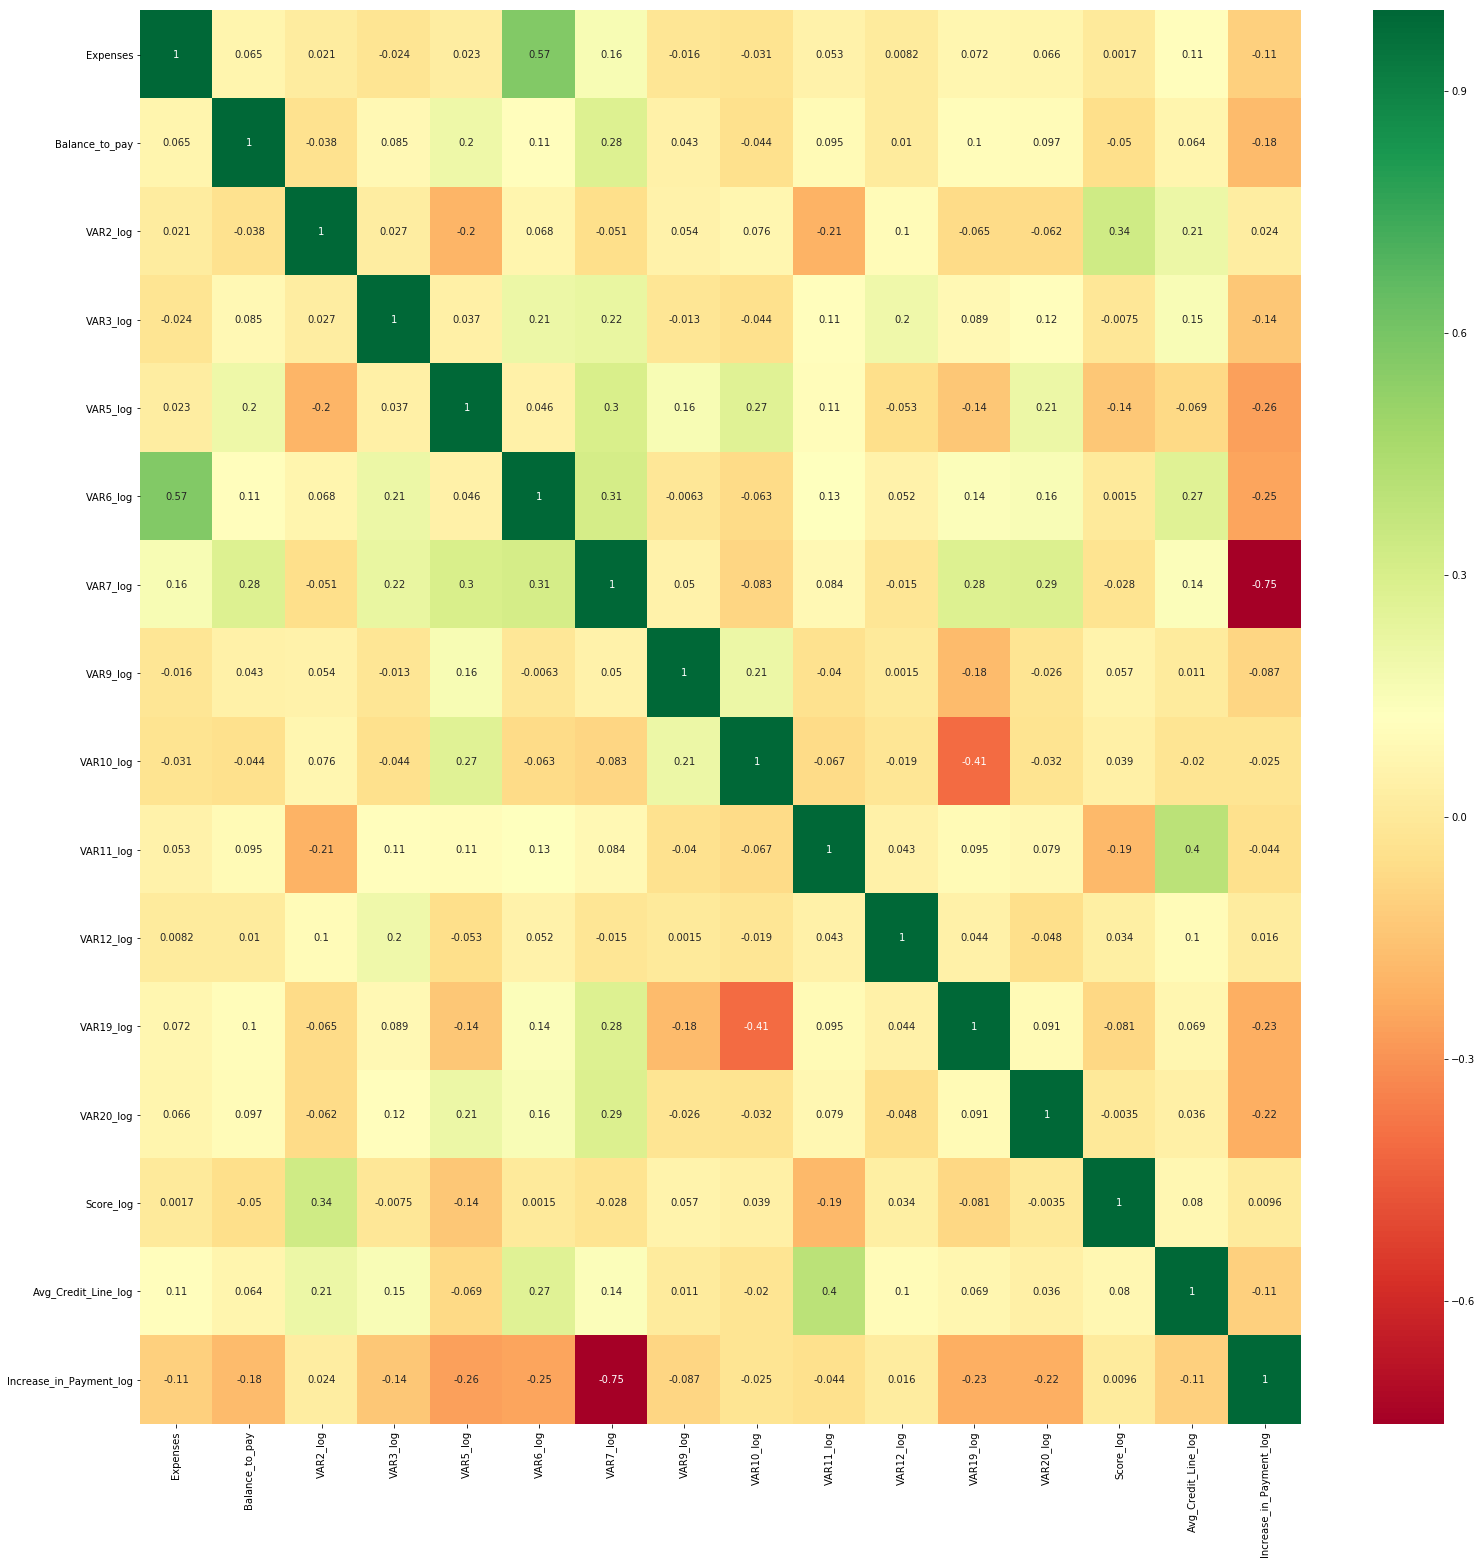

In [0]:
corrmat = X_imputed_feature.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(26,26))
#plot heat map
g=sns.heatmap(X_imputed_feature[top_corr_features].corr(),annot=True,cmap="RdYlGn")
# correlations = X_imputed_feature.corr()
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# ticks = np.arange(0,26,1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_yticklabels(X_imputed_feature.columns)
# plt.show()
# correlations

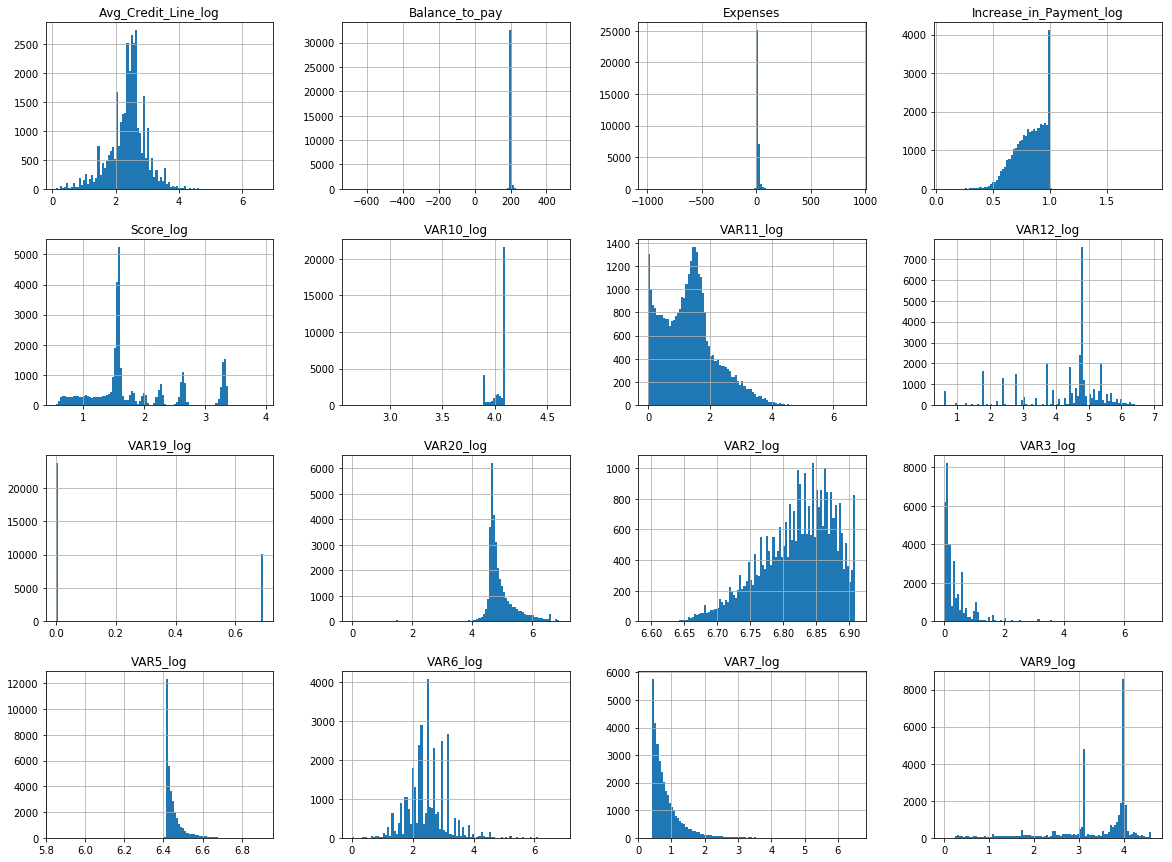

In [0]:
X_imputed_feature.hist(bins=100, figsize=(20,15))
plt.show()

In [0]:
# poly_features = PolynomialFeatures(degree=1)
# X_imputed_feature = pd.DataFrame(poly_features.fit_transform(X_imputed))
# features = X_imputed_feature.columns

In [0]:
scaler = StandardScaler()
X_imputed_scaled_feature = scaler.fit_transform(X_imputed_feature)

In [0]:
X_imputed_scaled_feature.shape

(33844, 16)

In [0]:
def amex_score(ytrain, ypred):
    metrics = [[ 1000,   -100,   -50],
               [ -200,   1000,  -100],
               [ -100,    -50,  1000]]
    score = metrics * confusion_matrix(ytrain, ypred)
    return score.sum()

In [0]:
def algo(clf, X, y):
    i=1
    kf = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
    scores = []
    scores_val = []

    for train_index,test_index in kf.split(X,y):    
        print('\n{} of kfold {}'.format(i,kf.n_splits))   
        xtr,xvl = np.array(X[train_index]),np.array(X[test_index])     
        ytr,yvl = np.array(y[train_index]),np.array(y[test_index])    
        clf.fit(xtr, ytr)
        pred = clf.predict(xtr)
        pred_test = clf.predict(xvl)
        s1 = (amex_score(ytr, pred)/ytr.shape[0]) * 10000
        s2 = (amex_score(yvl, pred_test)/yvl.shape[0]) * 10000
        scores.append(s1)
        scores.append(s2)
        i+=1
    
    return s1, s2

In [0]:
clf = xgboost.XGBClassifier(n_estimators = 100, max_depth = 5, learning_rate = 0.1, random_state = 7)
s1, s2 = algo(clf, X_imputed_scaled_feature, Y_encoded)
print('\n Train Score: ' + str(s1.mean()))
print('\n Test Score: ' + str(s2.mean()))
# parameters = {
#     'n_estimators' : [50, 100, 150],
#     'max_depth' : [1, 3, 5, 7, 9],
#     'learning_rate' : [0.003, 0.01, 0.03, 0.1, 0.3],
#     'booster' : ['gbtree', 'gblinear', 'dart']
# }
# gs = GridSearchCV(estimator = xgboost.XGBClassifier(random_state = 7), param_grid = parameters, n_jobs = 4, scoring = 'accuracy', iid =  False, cv = 3)
# gs.fit(X_imputed_scaled_feature,Y_encoded)
# gs.best_params_, gs.best_score_


1 of kfold 5

2 of kfold 5

3 of kfold 5

4 of kfold 5

5 of kfold 5

 Train Score: 5944302.862419206

 Test Score: 5470158.07357069


[0.04711909 0.04113386 0.08677973 0.13276853 0.03987776 0.05370645
 0.0469704  0.04053612 0.0434319  0.04339558 0.05688857 0.09032135
 0.10033426 0.08894404 0.0475168  0.04027554]


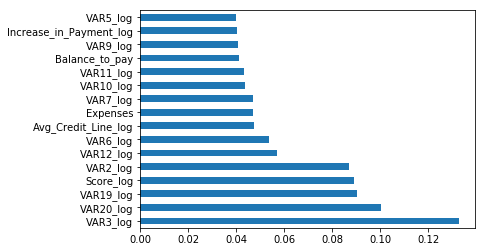

In [0]:
print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(clf.feature_importances_, index=features)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

In [0]:
forest_clf = RandomForestClassifier(n_estimators=150, max_depth=11, random_state = 7)
s1, s2 = algo(forest_clf, X_imputed_scaled_feature, Y_encoded)
print('\n Train Score: ' + str(s1.mean()))
print('\n Test Score: ' + str(s2.mean()))
# parameters = {
#     'n_estimators' : [50, 100, 150],
#     'max_depth' : [ 5, 7, 9, 11, 15],
#     'min_samples_split' : [2, 5, 10, 15]
# }
# gs1 = GridSearchCV(estimator = RandomForestClassifier(random_state = 7), param_grid = parameters, n_jobs = -1, scoring = 'accuracy', iid =  False, cv = 3)
# gs1.fit(X_imputed_scaled_feature,Y_encoded)
# gs1.best_params_, gs.best_score_


1 of kfold 5

2 of kfold 5

3 of kfold 5

4 of kfold 5

5 of kfold 5

 Train Score: 6619482.917820868

 Test Score: 5316221.0075343475


[0.05759029 0.05864036 0.08536477 0.0796567  0.05103181 0.04806383
 0.05374098 0.05028039 0.02561424 0.05806044 0.0565814  0.00767334
 0.14856355 0.09433829 0.07096193 0.05383769]


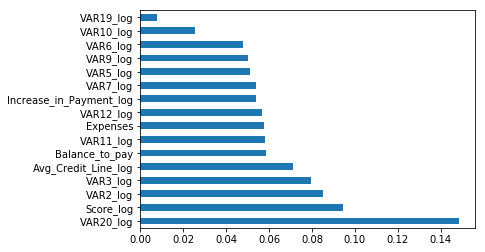

In [0]:
print(forest_clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(forest_clf.feature_importances_, index=features)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

In [0]:
lgbm_clf = LGBMClassifier(learning_rate=0.03, max_depth=11, n_estimators=150, random_state = 7)
s1, s2 = algo(lgbm_clf, X_imputed_scaled_feature, Y_encoded)
print('\n Train Score: ' + str(s1.mean()))
print('\n Test Score: ' + str(s2.mean()))
# parameters = {
#     'boosting_type ' : ['gbdt', 'dart', 'goss', 'rf'],
#     'max_depth' : [ 5, 7, 9, 11, 15],
#     'learning_rate' : [0.003, 0.01, 0.03, 0.1, 0.3],
#     'n_estimators' : [50, 100, 150],
# }
# gs2 = GridSearchCV(estimator = LGBMClassifier(random_state = 7), param_grid = parameters, n_jobs = -1, scoring = 'accuracy', iid =  False, cv = 3)
# gs2.fit(X_imputed_scaled_feature,Y_encoded)
# gs2.best_params_, gs.best_score_


1 of kfold 5

2 of kfold 5

3 of kfold 5

4 of kfold 5

5 of kfold 5

 Train Score: 5827608.494921515

 Test Score: 5384473.334318216


[ 603  765  904 1062  664  442  681  825  355  892  773  113 2290 1475
  999  657]


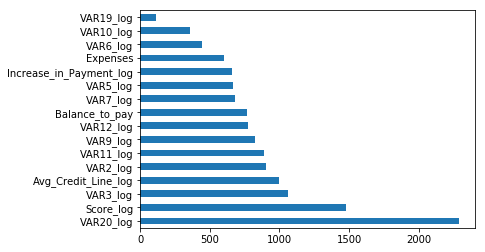

In [0]:
print(lgbm_clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(lgbm_clf.feature_importances_, index=features)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

In [0]:
voting_clf = VotingClassifier(
    estimators=[('xbg', clf), ('rf', forest_clf), ('lgbm', lgbm_clf)],
    voting='soft')
s1, s2 = algo(voting_clf, X_imputed_scaled_feature, Y_encoded)
print('\n Train Score: ' + str(s1.mean()))
print('\n Test Score: ' + str(s2.mean()))


1 of kfold 5

2 of kfold 5

3 of kfold 5

4 of kfold 5

5 of kfold 5

 Train Score: 6134367.497691598

 Test Score: 5401019.352932487


In [0]:
# Download files from Google Drive to Colab Notebook
id = '1U0r9q2LqNCShj1AZxXBBN9B4gJj4HDT2'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
dataset = pd.read_csv('Filename.csv')

In [0]:
final = pd.DataFrame(dataset['VAR1'])

In [0]:
del[dataset['VAR1']]
dataset['VAR14'].replace('.', np.nan, inplace = True)
dataset['VAR14'] = dataset['VAR14'].apply(pd.to_numeric)

features = dataset.columns
dataset_imputed = pd.DataFrame(fast_knn(dataset.values, k = 10), columns=features)

dataset_imputed_feature = cleaner(dataset_imputed)

dataset_imputed_scaled_feature = scaler.fit_transform(dataset_imputed_feature)

In [0]:
Y_pred = voting_clf.predict(dataset_imputed_scaled_feature)

In [0]:
Y_unencoded = ordinal_encoder.inverse_transform(Y_pred.reshape(-1, 1))

In [0]:
final['VAR2'] = Y_unencoded

In [0]:
final.head(20)

,VAR1,VAR2
0,1,Medium
1,2,Low
2,3,Medium
3,4,Low
4,5,Medium
5,6,Medium
6,7,Medium
7,8,Low
8,9,Medium
9,10,Medium


In [0]:
final.to_csv('Otomeya_IITRoorkee_46.csv', index = False, header = False)